# EDLIF model

[Jaras I, Harada T, Orchard ME, Maldonado PE, Vergara RC. Extending the integrate-and-fire model to account for metabolic dependencies. Eur J Neurosci. 2021 Aug;54(4):5249-5260. doi: 10.1111/ejn.15326. Epub 2021 Jul 16. PMID: 34109698.](https://onlinelibrary.wiley.com/doi/10.1111/ejn.15326)

[Free full article](https://www.researchgate.net/publication/352298690_Extending_the_integrate-and-fire_model_to_account_for_metabolic_dependencies)

### TODO:
- [] include equations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
load_module = True

if load_module:
    module_name = "edlif_psc_alpha_0_module"
    nest.Install(module_name)
    neuron_model = ["edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml.nestml"]
    synapse_model = ["ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml"]
    neuron_id = 0
else:
    neuron_model = [
        "edlif_psc_base.nestml", 
        "edlif_psc_nonlineardendrite.nestml",
        "edlif_psc_supply_state.nestml",
        "edlif_psc_supply_inline.nestml",
        "edlif_psc_percent.nestml",
        "../network/models/neurons/edlif_psc_alpha_percent.nestml"
    ]
    neuron_id = 5
    generate_nest_target(input_path=neuron_model[neuron_id],
                         target_path="/tmp/nestml-component",
                         logging_level="INFO",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})
    
    nest.Install("nestmlmodule")


Oct 05 11:34:39 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


Using neuron model: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml
idx: 0
idx: 1
spikes times: 1199
mean firing rate: 499.5833333333333


/tmp/ipykernel_14114/2185615260.py:125: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/tmp/ipykernel_14114/2185615260.py:125: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


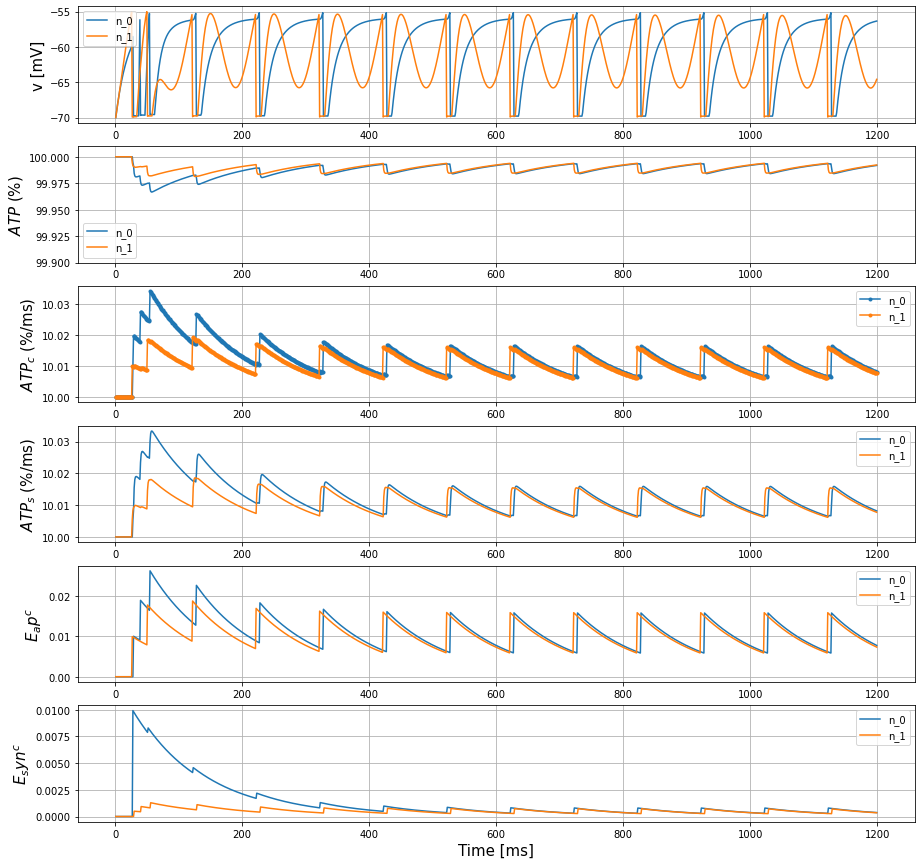

In [34]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

#param dict
parameter_dict = {"K_ATP": [1, 1], "ATP": [100, 100]}
n = 1

# create neurons
pop1 = nest.Create(neuron_model_name, n, params=parameter_dict)
pop2 = nest.Create(neuron_model_name, n, params=parameter_dict)
voltmeter1 = nest.Create("voltmeter")
voltmeter2 = nest.Create("voltmeter")
voltmeter = [voltmeter1, voltmeter2]

for neuron in [pop1, pop2]:
    neuron.tau_m = 20 #20
    neuron.tau_syn_ex = 6
    neuron.tau_syn_in = 6
    neuron.C_m = 250 #250
    neuron.t_ref = 8 #2
    # energy params
    neuron.K_ATP = 1
    neuron.gamma = 178
    neuron.tau_ap = 100
    neuron.E_ap = 1
    neuron.E_rp = 5
    neuron.E_hk = 5
    neuron.E_syn_ex = neuron.E_ap/2
    neuron.E_syn_in = neuron.E_ap/2
    neuron.tau_syn_atp_ex = 100
    neuron.tau_syn_atp_ex = 100

# create connections
syn_dict = {"synapse_model": synapse_model[0], 
            "w": 500,
            #"alpha": 1
            }
nest.Connect(pop1, pop2,
             "one_to_one",
             syn_spec=syn_dict)
syn_dict2 = {"synapse_model": synapse_model[0], 
            "w": 2000,
            #"alpha": 1
            }
nest.Connect(pop2, pop1,
             "one_to_one",
             syn_spec=syn_dict2)

voltmeter[0].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
voltmeter[1].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter1, pop1)
nest.Connect(voltmeter2, pop2)

# current generators
dcs = nest.Create('dc_generator')
dcs.set({"amplitude": 176.01})   
dcs.set({"stop": 1500})
acs = nest.Create('ac_generator')
acs.set({"amplitude": 150.2})
acs.set({"offset": 150.2})
acs.set({"frequency": 10})
acs.set({"stop": 1500})
nest.Connect(dcs, pop1)
nest.Connect(acs, pop2)

# spike recorder
sr = nest.Create("spike_recorder")
nest.Connect(pop1, sr)
nest.Connect(pop2, sr)

simtime = 1000.*1.2
nest.Simulate(simtime)

# new arrays for reshaped arrays
ts = []
Vms = []
atp = []
atp_h = []
atp_c = []
atp_s = []
e_ap_c = []
e_syn_c = []
st = []

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))

for idx in range(2):
    # reshape arrays
    print(f"idx: {idx}")
    ts.append(voltmeter[idx].get("events")["times"])
    Vms.append(voltmeter[idx].get("events")["V_m"])
    atp.append(voltmeter[idx].get("events")["ATP"])
    atp_h.append(pop1.get("ATP_h"))
    atp_c.append(voltmeter[idx].get("events")["ATP_c"])
    atp_s.append(voltmeter[idx].get("events")["ATP_s"])
    e_ap_c.append(voltmeter[idx].get("events")["E_ap_c"])
    e_syn_c.append(voltmeter[idx].get("events")["E_syn_c"])
    
    # plot
    ax[0].plot(ts[idx], Vms[idx], label=f"n_{idx}")
    ax[1].plot(ts[idx], atp[idx], label=f"n_{idx}")
    ax[1].set_ylim(99.9, 100.01)
    #ax[1].axhline(y=atp_h[idx], ls="--")
    ax[2].plot(ts[idx], atp_c[idx], marker ='.', label=f"n_{idx}")
    #ax[2].axhline(y=pop1.get("ATP_basal"), ls="--")
    ax[3].plot(ts[idx], atp_s[idx], label=f"n_{idx}")
    ax[4].plot(ts[idx], e_ap_c[idx], label=f"n_{idx}")
    ax[5].plot(ts[idx], e_syn_c[idx], label=f"n_{idx}")
    for _ax in ax:
        _ax.grid(True)
        _ax.legend()
    ax[0].set_ylabel("v [mV]", fontsize=fontsize)
    ax[1].set_ylabel("$ATP$ (%)", fontsize=fontsize)
    ax[2].set_ylabel("$ATP_c$ (%/ms)", fontsize=fontsize)
    ax[3].set_ylabel("$ATP_s$ (%/ms)", fontsize=fontsize)
    ax[4].set_ylabel("$E_ap^{tr}$", fontsize=fontsize)
    ax[4].set_ylabel("$E_ap^c$", fontsize=fontsize)
    ax[5].set_ylabel("$E_syn^c$", fontsize=fontsize)
    ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
    
    fig.show()
    
spike_times = voltmeter[0].get("events")["times"] + voltmeter[1].get("events")["times"]
print(f'spikes times: {len(spike_times)}')
print(f'mean firing rate: {len(spike_times)/(simtime*2) * 1000}')

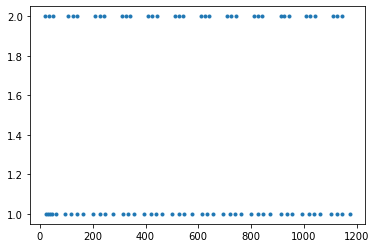

In [25]:
# extracting spikes data
dSD = sr.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.plot(ts, evs, ".")

In [5]:
conns = nest.GetConnections(synapse_model="stdp_synapse")

In [6]:
conns.get("weight")

()

In [7]:
conns.get("target")

()

In [8]:
conns.get(["source", "target","weight"])

()